In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

### Analysis steps
#### The first step of the analysis is to identify ID switches of territorial males and stitch these IDs together to create long uninterrupted trajectories for each of them. 

0. Check videos to identify what comprises a single flight.
1. Identify IDs of territorial males on frame 0 of video 294.
2. Check the length / duration these IDs persist to get a sense of the timescale at which ID switches occur. Do this for the entire flight. 
3. Filter out male IDs that persist longer than video 294. Now we only have individuals that are either not territorial, or that have experienced ID switches.
4. Plot a convex hull / Kernel Density Estimate around the trajectories of each of these individuals to find overlap.
5. Check timestamps / frame numbers of IDs that overlap in area.
6. Use this information to inform yourself what IDs may have changed and verify them on the video (plotted with opencv).

In [2]:
# Analysis parameters
fps = 30.0
max_gap_seconds = 1.0    # time gap beyond which speed is not calculated (in seconds)
smoothing_window = 500  # (in milliseconds)

In [3]:
# Helper functions
def smooth_over_time(df, window_size=0.5):
    """
    This function smooths a timeseries over a fixed time window (seconds)
    
    Parameters
    ----------
    df: DataFrame, shape(n_rows, n_cols)
        dataframe containing columns for the smoothing variable and for time in seconds.
    window_size: int(optional), default = 0.5
        window_size determines the width of the kernel used for smoothing.
        Note: window_size is preferrably odd.
        
    Returns
    -------
    df: DataFrame, shape(n_rows, n_cols+1)
        dataframe with an added column for the smoothed speed
    """
    
    # Use time_s as the index (important for time-based rolling)
    df = df.sort_values('time_s').set_index('time_s')

    # Use a time-based rolling window by converting seconds to timedelta
    df.index = pd.to_timedelta(df.index, unit='s')

    smoothed = df['speed'].rolling(f"{window_size}ms", min_periods=1, center=True).mean()

    df['speed_smoothed'] = smoothed.values
    return df.reset_index(drop=False)

In [4]:
# Load data
df = pd.read_csv('/Volumes/SSD5/processed/Field_Recording_2023/SpatialRegistration/20230313/SE_Lek1/P1D1/20230313_SE_Lek1_P1D1_DJI_0294_3D_trajectories_utm.csv')
df = df.loc[:,['frame', 'Point', 'class_id', 'easting', 'northing']]
df.head()

,frame,Point,class_id,easting,northing
0,0,1100001,1.0,444552.385492,3.075119e+06
1,0,1100002,1.0,444588.497858,3.075105e+06
2,0,1100003,0.0,444508.432204,3.075122e+06
3,0,1100004,1.0,444574.869145,3.075144e+06
4,0,1100005,1.0,444550.203567,3.075174e+06


In [5]:
df = df.sort_values(['Point', 'frame']).reset_index(drop=True)

# Calculate individual speeds
# this requires computing the instantaneous displacements of individuals over time (ds)
df[['dx', 'dy']] = df.groupby('Point')[['easting', 'northing']].diff()
df['distance'] = np.sqrt(df['dx'].pow(2) + df['dy'].pow(2))

# and the time difference in which these displacements occurred (dt)
df['frame_diff'] = df.groupby('Point')['frame'].diff()
df['dt_seconds'] = df['frame_diff'] / fps

# speed is distance / dt_seconds
df['speed'] = df['distance'] / df['dt_seconds']

In [6]:
# ensure speed calculations are instantaneous speeds
df.loc[df['dt_seconds'] > max_gap_seconds, 'speed'] = np.nan

# convert frame to time in seconds for plotting
df['time_s'] = df['frame'] / fps

# smooth speed over a window of length 'smoothing_window'
df = (df.groupby('Point', group_keys=False).apply(lambda s: smooth_over_time(s, smoothing_window)))

In [7]:
# Consider 'n' individuals with the highest number of rows to plot
n_inds_include = 20

counts = df['Point'].value_counts()    # this function's default behaviour is to sort points by their counts
valid_points = counts.head(n_inds_include).index

min_count_included = counts.head(n_inds_include).min()
print(f"Including top {n_inds_include} Points.")
print(f"Minimum detection count among these = {min_count_included}")

Including top 20 Points.
Minimum detection count among these = 5802


In [8]:
df_plot = df[(df['time_s'] < pd.Timedelta(seconds=15)) & (df['Point'].isin(valid_points))]

# Create a color map for each Point
points = df_plot['Point'].unique()
cmap = plt.colormaps.get_cmap('rainbow')
colors = [cmap(i / len(points)) for i in range(len(points))]
point_color_map = {point: colors[i] for i, point in enumerate(points)}

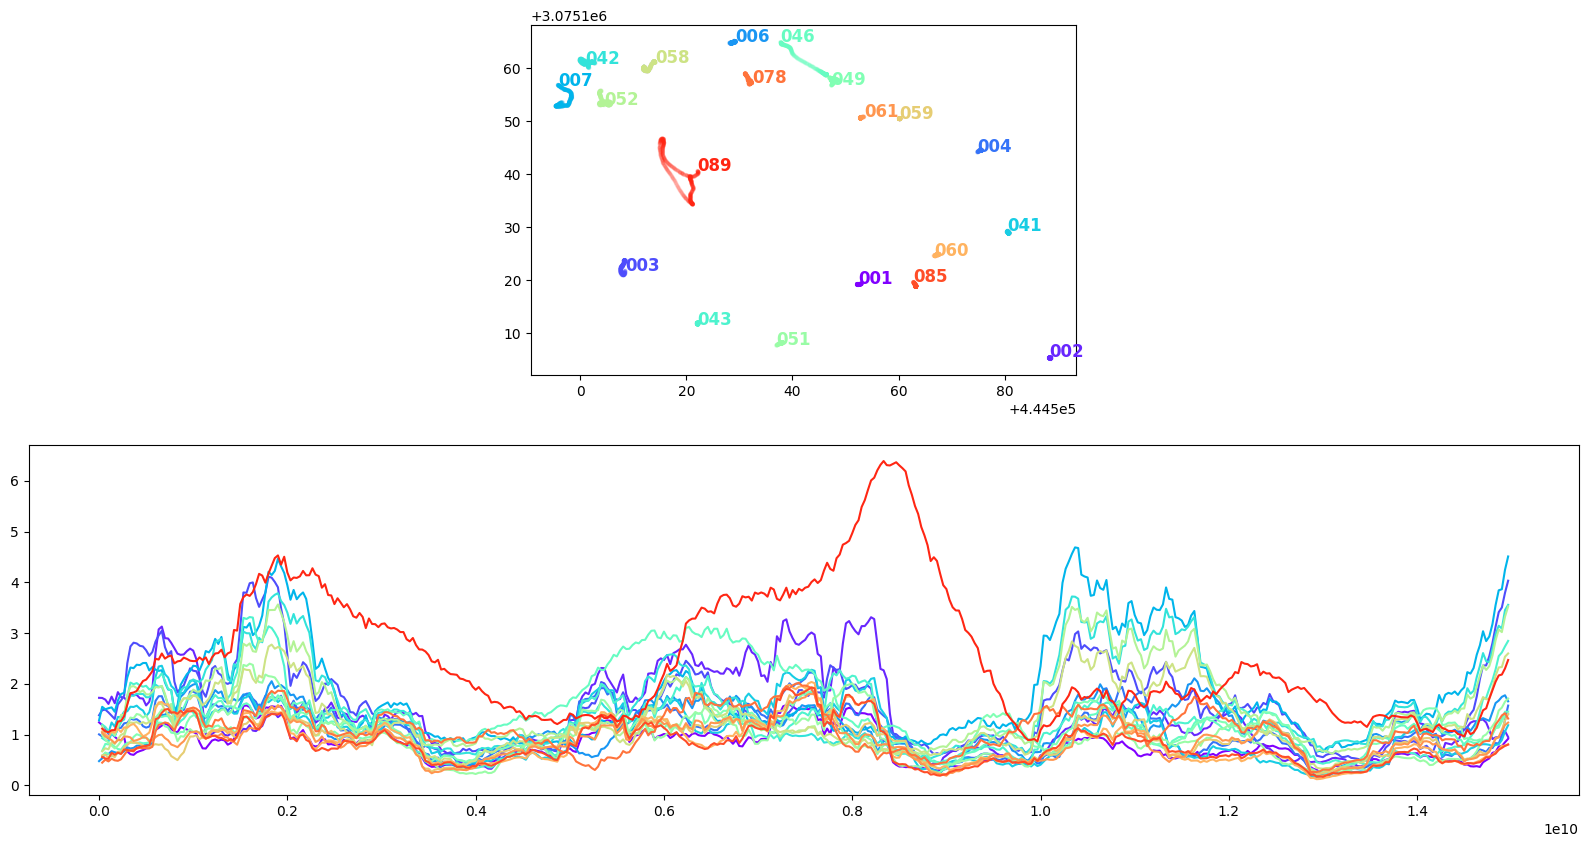

In [9]:
# Plot the trajectories and speed timeseries 
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,10))

ax1.scatter(df_plot['easting'], df_plot['northing'], c=df_plot['Point'].map(point_color_map), s=5, alpha=0.1)
ax1.set_aspect('equal')

# Add text labels once per Point
for pt in points:
    df_point = df_plot[df_plot['Point'] == pt]
    # Pick the first row as representative
    x, y = df_point.iloc[0][['easting', 'northing']]
    ax1.text(x, y, str(pt)[-3:], color=point_color_map[pt], fontsize=12, weight='bold')

for pt in points:
    df_point = df_plot[df_plot['Point'] == pt]
    ax2.plot(df_point['time_s'], df_point['speed_smoothed'], color=point_color_map[pt])
plt.show()

In [10]:
# Construct a correlation matrix with the speeds
speed_mat = (df[df['Point'].isin(valid_points)]
             .pivot_table(index='frame', columns='Point', values='speed_smoothed').sort_index(axis=1))

corr_mat = speed_mat.corr(method='kendall')
# check the number and effect of nans in the data
# if they're a problem, should one replace them with zeros or the mean value for that column?

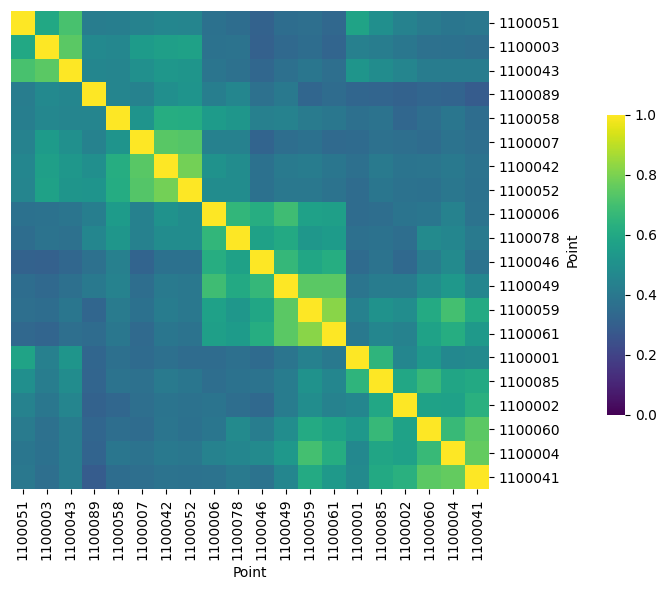

In [11]:
# Plot the correlation matrix
cluster = sns.clustermap(corr_mat, method='average', metric='correlation', cmap='viridis', 
                         vmin=0, vmax=1, dendrogram_ratio=0.001, figsize=(6, 6), cbar_pos=(1.02, 0.3, 0.03, 0.5))

# Shorten tick labels to show only last 3 characters
# new_labels = [lbl.get_text()[-3:] for lbl in cluster.ax_heatmap.get_xticklabels()]
# cluster.ax_heatmap.set_xticklabels(new_labels, rotation=90)

# new_labels = [lbl.get_text()[-3:] for lbl in cluster.ax_heatmap.get_yticklabels()]
# cluster.ax_heatmap.set_yticklabels(new_labels, rotation=0)

plt.show()